In [1]:
import matplotlib.pyplot as plt
from time import time, sleep
import pandas as pd
import subprocess
import numpy as np
from scipy import integrate

In [2]:
# Chemin du fichier de mesure de puissance
path = "/sys/class/hwmon/hwmon1/"
file = "power1_input"
power_file = path + file

In [3]:
# Fonction pour lire la puissance
def read_power():
    with open(power_file, "r") as f:
        return int(f.read()) / 1000  # Convertir en watts

In [4]:
# Initialiser les listes de stockage des mesures
power = []
t = []
init = time()
ventana = 1
t_total = 70  # Durée totale de mesure (en secondes)
actual = time()

In [5]:
# Mesurer la puissance avant l'exécution du script 
print("Mesure de la consommation AVANT l'exécution du script...")
pre_time = 20  # Durée d'observation avant lancement (secondes)
for _ in range(int(pre_time / 0.1)):  # Prendre des mesures toutes les 0.1s
    t.append(time() - init)
    power.append(read_power())
    sleep(0.1)

Mesure de la consommation AVANT l'exécution du script...


In [6]:
#  Lancer le script en arrière-plan 
print("Démarrage du script mlp_dpu.py...")
process = subprocess.Popen(["python3", "mlp_dpu.py"])

# Mesurer la consommation pendant l'exécution du script
while ventana:
    if time() > actual + 0.1:  # Mesurer toutes les 0.1 seconde
        t.append(time() - init)
        power.append(read_power())
        actual = time()

    # Arrêter la mesure après t_total secondes ou si le script est terminé
    if (time() - init) > t_total or process.poll() is not None:
        ventana = 0

# Attendre que le script se termine (au cas où il dure moins que t_total)
process.wait()

Démarrage du script mlp_dpu.py...
Précision: 93.87%


0

In [7]:
#  Mesurer la consommation après l'exécution du script 
print("Mesure de la consommation APRÈS l'exécution du script...")
post_time = 20  # Durée d'observation après exécution (secondes)
for _ in range(int(post_time / 0.1)):  # Mesurer toutes les 0.1s
    t.append(time() - init)
    power.append(read_power())
    sleep(0.1)

Mesure de la consommation APRÈS l'exécution du script...


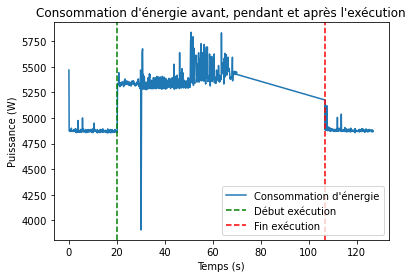

In [14]:
#  Tracer la courbe de puissance 
plt.plot(t, power, label="Consommation d'énergie")
plt.axvline(pre_time, color="green", linestyle="--", label="Début exécution")
plt.axvline(t[-1] - post_time, color="red", linestyle="--", label="Fin exécution")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (W)")
plt.title("Consommation d'énergie avant, pendant et après l'exécution")
plt.legend()
plt.savefig("consommation_energie.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
#Sauvegarder les données dans un fichier CSV 
df = pd.DataFrame(data={"temps": t, "puissance": power})
df.to_csv("power_measurement.csv", index=False)

In [10]:
# Calculer l'énergie totale consommée 
power_np = np.array(power) / 1000  # Convertir en kW pour l'intégration
energy = integrate.simpson(power_np, x=t)
print(f"Énergie totale consommée : {energy:.2f} Joules")

Énergie totale consommée : 952.56 Joules


In [11]:
# Afficher la puissance moyenne
mean_power = np.mean(power_np)
print(f"Puissance moyenne : {mean_power:.2f} W")

Puissance moyenne : 5.15 W
